In [117]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from konlpy.tag import Okt
from tqdm import tqdm

pd.options.display.float_format = '{:.0f}'.format
#pd.reset_option('display.float_format')
self_review = pd.read_csv('/Users/wonsik/GitHub/chack-it-out-2/data/self_review.csv', lineterminator='\n', index_col=0)
economy_review = pd.read_csv('/Users/wonsik/GitHub/chack-it-out-2/data/economy_review.csv', lineterminator='\n', index_col=0)

In [118]:
def review_textmining(dataframe):
    dataframe = dataframe.rename(columns={'0':'isbn13'})
    dataframe = dataframe.rename(columns={'1':'score'})
    dataframe = dataframe.rename(columns={'2':'reviews'})
    dataframe = dataframe.rename(columns={'3':'date'})
    dataframe = dataframe.rename(columns={'3\r':'date'})
    dataframe = dataframe.dropna(subset=['isbn13'])         
    
    # 중복 제거
    dataframe.drop_duplicates(subset=['reviews'], inplace=True)
    # $2022-10 형식 제거
    dataframe['reviews'] = [re.sub(r"[$]{1,4}[0-9]{4}-[0-9]{1,2}", " ", review) for review in dataframe['reviews']]
    # URL 제거, http로 시작되는 url
    dataframe['reviews'] = [re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", review) for review in dataframe['reviews']]
    # 한글 제외하고 제거
    dataframe['reviews'] = [re.sub(r"[^ㄱ-ㅎ가-힣]", " ", review) for review in dataframe['reviews']]
    # 공백 여러번 -> 1번
    dataframe['reviews'] = [re.sub(r"\s+", " ", review) for review in dataframe['reviews']]
    # 한 글자 자음 제거
    dataframe['reviews'] = [re.sub(r"([ㄱ-ㅎㅏ-ㅣ])+", " ", review) for review in dataframe['reviews']]
    # 중복 제거
    dataframe.drop_duplicates(subset=['reviews'], inplace=True)
    
    return dataframe

In [119]:
def review_concat(df1, df2):
    df1 = review_textmining(df1) 
    df2 = review_textmining(df2) 
    total_review = pd.concat([df1, df2], axis = 0, sort=False)
    total_review.drop_duplicates(subset=['reviews'], inplace=True)
    total_review.reset_index(drop=True, inplace=True)
    
    return total_review

In [120]:
total_review = review_concat(self_review, economy_review)
total_review

,isbn13,score,reviews,date
0,9791168473690,10,선생님 항상 존경합니다 저도 한 때는 만원 들고 가출한 적이 있으나 선생님의 뼈아픈...,2023-01-20
1,9791168473690,2,와 최악이다 이게 책인가 반품 신청함 말도 너무 험하고 몇 챕터 읽었는데 기분만 상했음,2023-03-04
2,9791168473690,4,이전에 비매품으로 나왔던 책도 소장중입니다만 수정본이라도 내용상 크게 변한 건 없군...,2023-03-05
3,9791168473690,2,가르침 이란 제목에서 알아봤어야 했는데,2023-03-03
4,9791168473690,10,지금 현재 흙수저에서 부자가 된 사람들의 대다수는 세이노 선생님이 멘토셨다 약 년전...,2023-01-22
...,...,...,...,...
136211,9788997323524,10,유통업체에 푸드코트 납품 입점하실 분들은 이 자료 이용하셔서 발송하시고 매장관리자 ...,2012-08-23\r
136212,9788997323418,8,유통쪽에서 일하는지라 본사말고 개인음식점들 컨텍할 자료가 필요했는데 괜찮네요 정보가...,2012-04-25\r
136213,9788960237872,8,출산률이 마음대로 될까 하는 생각이 드는 목차가 있네요,2012-05-17\r
136214,9788982732362,10,근데 이사람 왜 파산했을까요,2016-10-01\r


In [434]:
#total_review.to_csv('total_review.csv', encoding='utf-8-sig')

In [121]:
total_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136216 entries, 0 to 136215
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   isbn13   136216 non-null  float64
 1   score    136216 non-null  int64  
 2   reviews  136216 non-null  object 
 3   date     136216 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [34]:
# 명사
okt = Okt()
review_noun_okt = []
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.flatten()

for review in tqdm(total_review['reviews']):
    Noun = []
    Noun = {term[0] for term in okt.pos(review, stem=True, norm=True) if term[1] in ["Noun"]} # 토큰화
    Noun = list(Noun)
    Noun = [x for x in Noun if x not in stopwords]  # 불용어 제거
    Noun = [x for x in Noun if len(x) > 1]  # 한글자 키워드 제거
    if Noun : 
        review_noun_okt.append(Noun) #빈 list는 추가X

100%|██████████████████████████████████| 136216/136216 [13:40<00:00, 166.04it/s]


In [48]:
# 배열 생성
#review_noun_okt

# 배열 저장
#with open('review_noun_okt.pkl', 'wb') as f:
#    pickle.dump(review_okt, f)

# 다른 노트북에서 배열 불러오기
with open('review_noun_okt.pkl', 'rb') as f:
    review_noun_okt = pickle.load(f)
    

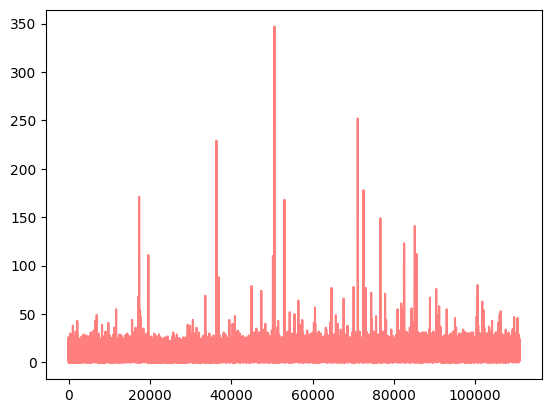

In [122]:
string_len = [len(x) for x in review_okt]
plt.plot(string_len, alpha=0.5, color='red')

In [137]:
string_len = [len(x) for x in review_okt]
del_review = [idx for idx, str_len in enumerate(string_len) if str_len > 100]
total_review = total_review[~total_review.index.isin(del_review)]

In [138]:
# 라벨링
total_review['label'] = pd.cut(total_review['score'],
    bins = [0, 8, 10],
    labels = [0, 1])

/var/folders/yt/t0fd6yq13pv4w1sq7rhww2040000gn/T/ipykernel_21045/3374142891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_review['label'] = pd.cut(total_review['score'],


In [145]:
total_review

,isbn13,score,reviews,date,label
0,9791168473690,10,선생님 항상 존경합니다 저도 한 때는 만원 들고 가출한 적이 있으나 선생님의 뼈아픈...,2023-01-20,1
1,9791168473690,2,와 최악이다 이게 책인가 반품 신청함 말도 너무 험하고 몇 챕터 읽었는데 기분만 상했음,2023-03-04,0
2,9791168473690,4,이전에 비매품으로 나왔던 책도 소장중입니다만 수정본이라도 내용상 크게 변한 건 없군...,2023-03-05,0
3,9791168473690,2,가르침 이란 제목에서 알아봤어야 했는데,2023-03-03,0
4,9791168473690,10,지금 현재 흙수저에서 부자가 된 사람들의 대다수는 세이노 선생님이 멘토셨다 약 년전...,2023-01-22,1
...,...,...,...,...,...
136211,9788997323524,10,유통업체에 푸드코트 납품 입점하실 분들은 이 자료 이용하셔서 발송하시고 매장관리자 ...,2012-08-23\r,1
136212,9788997323418,8,유통쪽에서 일하는지라 본사말고 개인음식점들 컨텍할 자료가 필요했는데 괜찮네요 정보가...,2012-04-25\r,0
136213,9788960237872,8,출산률이 마음대로 될까 하는 생각이 드는 목차가 있네요,2012-05-17\r,0
136214,9788982732362,10,근데 이사람 왜 파산했을까요,2016-10-01\r,1


In [147]:
total_review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136202 entries, 0 to 136215
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   isbn13   136202 non-null  float64 
 1   score    136202 non-null  int64   
 2   reviews  136202 non-null  object  
 3   date     136202 non-null  object  
 4   label    136202 non-null  category
dtypes: category(1), float64(1), int64(1), object(2)
memory usage: 5.3+ MB
